# Определение стоимости автомобилей

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. Имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Значение метрики RMSE для выбранной модели должно быть меньше 2500

**План работы:**  
1. Подготовка данных, в том числе:  
    1.1 Загрузка и изучение файла с данными  
    1.2 Исправление названий признаков  
    1.3 Обработка пропущенных значений  
    1.4 Избавление от дубликатов  
    1.5 Избавление от не информативных признаков  
    1.6 Избавление от выбивающихся численных значений  
    1.7 Разбивка данных на выборки и отделение целевого признака  
    1.8 Кодирование категориальных признаков  
2. Обучение моделей, в том числе:  
    2.1 Обучение и оценка качества модели градиентного бустинга  
    2.2 Обучение и оценка качества модели случайного леса  
    2.3 Обучение и оценка качества модели линейной регрессии  
    2.4 Сравнение качества моделей  
3. Анализ моделей, в том числе:  
    3.1 Проверка качества лучшей модели на тестовой выборке  
    3.2 Проверка лучшей модели на адекватность  
4. Общий вывод

**Описание данных:**  
Целевой признак - цена автомобиля в евро `Price`.  

Остальные признаки:  
•	`DateCrawled` — дата скачивания анкеты из базы  
•	`VehicleType` — тип автомобильного кузова  
•	`RegistrationYear` — год регистрации автомобиля  
•	`Gearbox` — тип коробки передач  
•	`Power` — мощность (л. с.)  
•	`Model` — модель автомобиля  
•	`Kilometer` — пробег (км)  
•	`RegistrationMonth` — месяц регистрации автомобиля  
•	`FuelType` — тип топлива  
•	`Brand` — марка автомобиля  
•	`Repaired` — была машина в ремонте или нет  
•	`DateCreated` — дата создания анкеты  
•	`NumberOfPictures` — количество фотографий автомобиля  
•	`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
•	`LastSeen` — дата последней активности пользователя  

## Подготовка данных

In [1]:
import numpy as np
import os
import pandas as pd
import time

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import scipy.stats as st

from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

### Загрузка и изучение файла с данными

Выведем первые 10 строк файла и изучим общую информацию

In [2]:
pth1 = 'datasets/autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=['DateCrawled','DateCreated','LastSeen'], dayfirst=True)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=['DateCrawled','DateCreated','LastSeen'], dayfirst=True)
else:
    print('Файл с данными не найден')

In [3]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Названия признаков следует привести к змеиному регистру.  
`Repaired` можно привести к типу `bool`, но в итоге этот признак всё равно будет использоваться как категориальный.  
На всякий случай проверим, что в данных нет существенного разброса по годам создания анкет.

In [5]:
pd.to_datetime(df['DateCreated'], errors='coerce').dt.year.value_counts()

2016    354343
2015        25
2014         1
Name: DateCreated, dtype: int64

Явные пропуски:

In [6]:
def pass_value_barh(df):
    try:
        (df.isna().sum()) \
        .to_frame() \
        .rename(columns = {0:'space'}) \
        .query('space > 0') \
        .sort_values(by = 'space', ascending = True) \
        .plot(kind= 'barh', figsize=(19,10), rot = -5, legend = False, fontsize = 16) \
        .set_title('Явные пропуски ', fontsize = 22, color = 'SteelBlue')
        plt.ylabel('Признаки', fontsize = 18, color = 'SteelBlue')
        plt.xlabel('Количество пропусков', fontsize = 18, color = 'SteelBlue')  
    except:
        print('Явных пропусков не осталось')

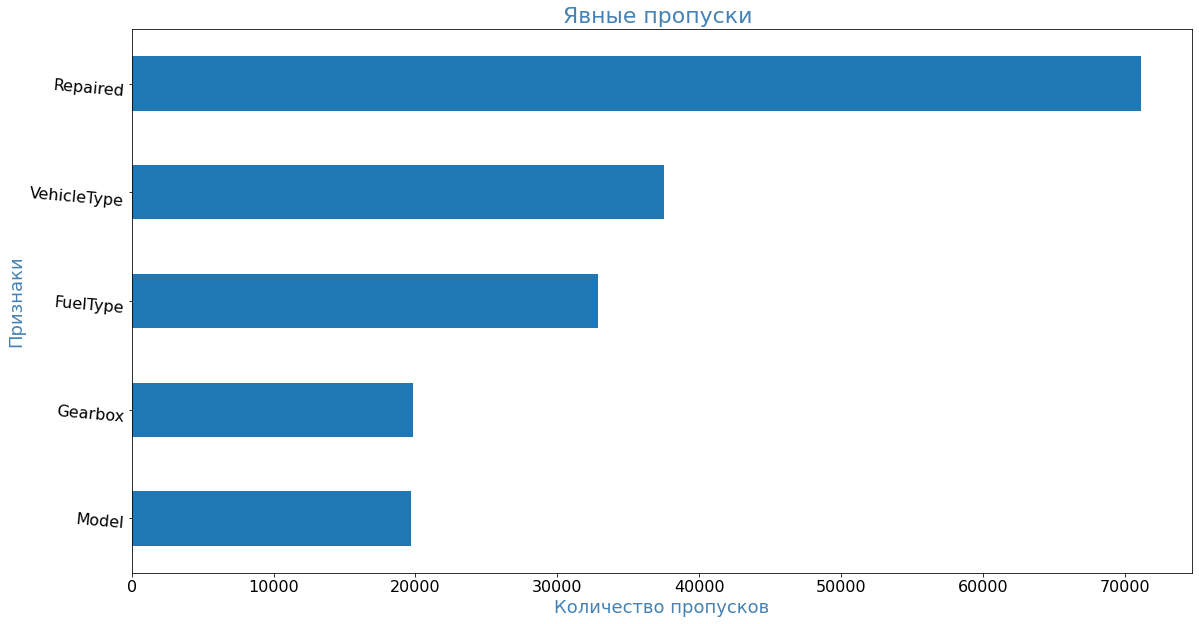

In [7]:
pass_value_barh(df)

Для признаков `Price`, `RegistrationYear`, `Power`, `Kilometer`, `RegistrationMonth`, `PostalCode` возможны также неявные пропуски - значения `0`.  
Проверим, не начинается ли счёт месяцев с нуля (тогда 12-й месяц будет отсутствовать)

In [8]:
df['RegistrationMonth'].value_counts(sort=False)

0     37352
1     23219
2     21267
3     34373
4     29270
5     29153
6     31508
7     27213
8     22627
9     23813
10    26099
11    24186
12    24289
Name: RegistrationMonth, dtype: int64

Найдём количество нулевых значений у признаков аналогично количеству явных пропусков

In [9]:
def pass_value_zero_barh(df):
    try:
        ((df==0).sum()) \
        .to_frame() \
        .rename(columns = {0:'space'}) \
        .query('space > 0') \
        .sort_values(by = 'space', ascending = True) \
        .plot(kind= 'barh', figsize=(19,10), rot = -5, legend = False, fontsize = 16) \
        .set_title('Количество нулевых значений ', fontsize = 22, color = 'SteelBlue')
        plt.ylabel('Признаки', fontsize = 18, color = 'SteelBlue')
        plt.xlabel('Количество нулевых значений', fontsize = 18, color = 'SteelBlue')  
    except:
        print('Нулевых значений не осталось')

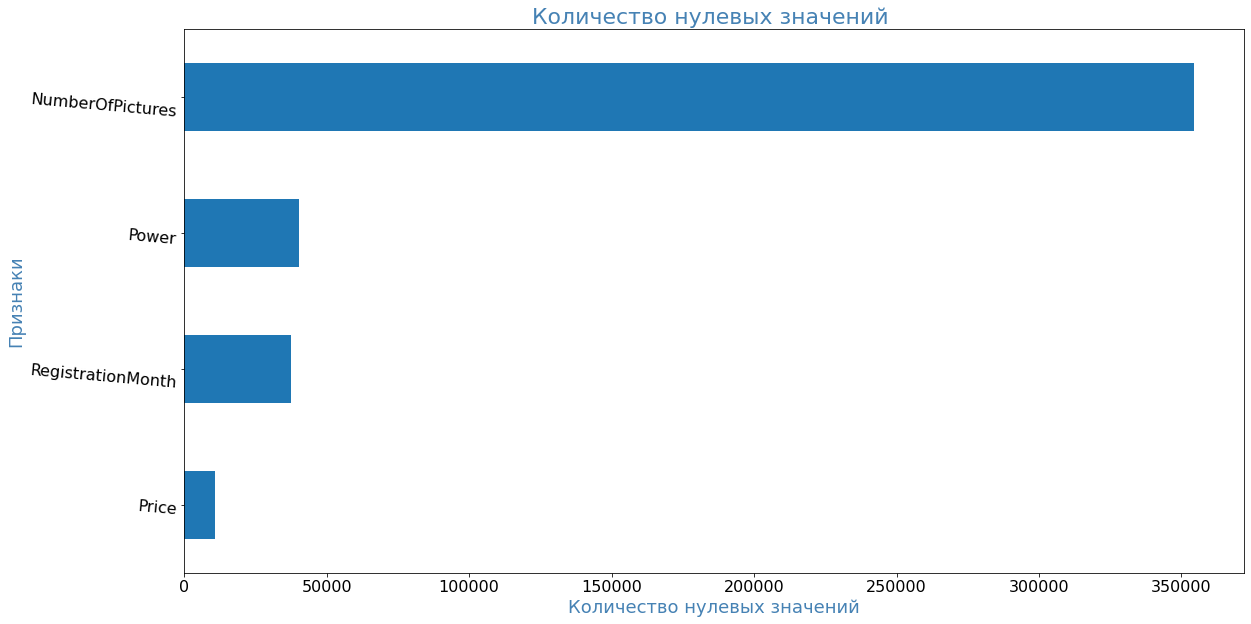

In [10]:
pass_value_zero_barh(df)

Итого, у признаков `Power`, `RegistrationMonth` и `Price` есть неявные пропуски. Похоже, признак `NumberOfPictures` полностью состоит из нулей, и является не информативным:

In [11]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

### Исправление названий признаков

Приведём названия признаков к змеиному регистру

In [12]:
# заменяем заглавные буквы на строчные с подчёркиванием, убираем подчёркивания в начале названия
def camel_to_snake(s):
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [13]:
df = df.rename(camel_to_snake, axis='columns')
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Обработка пропущенных значений

Для признака `repaired` заполним пропуски значением `unknown`, так как мы не можем точно определить, была ли данная машина в ремонте. Аналогично поступим с `model`

In [14]:
df['repaired'].fillna('unknown', inplace=True)
df['model'].fillna('unknown', inplace=True)

Зная `model`, мы можем правдоподобно заполнить пропуски в `gearbox`, `fuel_type` и `vehicle_type`. Оставшиеся значения также заменим на `unknown`.

In [15]:
for col in ['gearbox','fuel_type','vehicle_type']:
    df[col] = df.groupby('model', sort=False)[col].apply(lambda x: x.ffill().bfill())
    df[col].fillna('unknown', inplace=True)

Явных пропусков не осталось


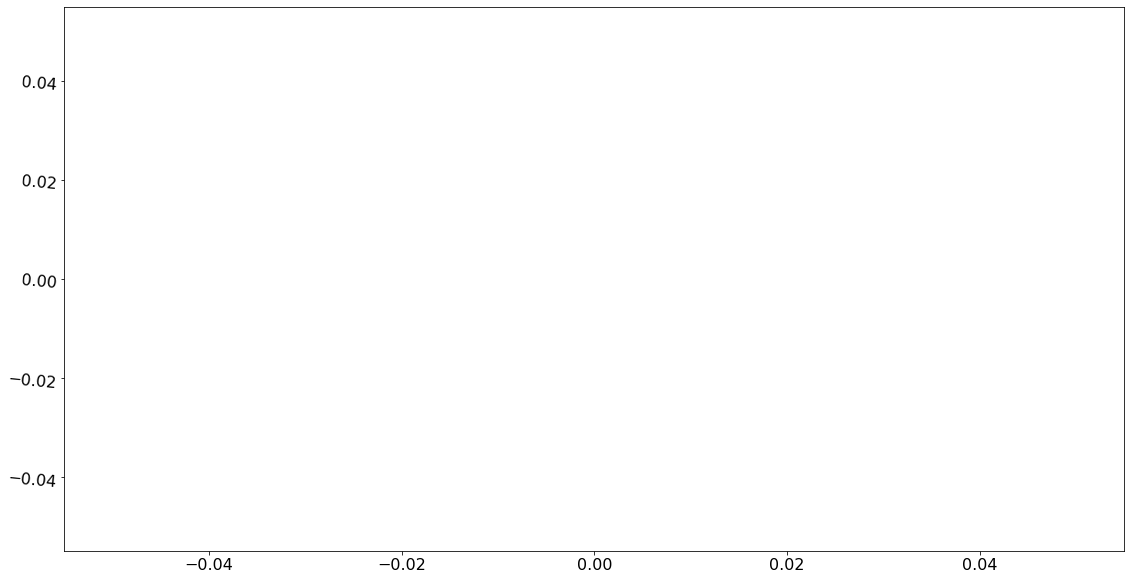

In [16]:
pass_value_barh(df)

Нулевые значения `power` заменим на медианные по данной модели `model` автомобиля и удалим оставшиеся пропуски:

In [17]:
df['power'] = df['power'].replace(0, np.nan)
df['power']=df['power'].fillna(df.groupby('model')['power'].transform('median'))
df.drop(df[df['power'].isnull()].index, inplace=True)

Поскольку месяц регистрации автомобиля - не информативный признак (в сравнении с годом регистрации), оставим его без изменений  
Объекты с нулём в целевом признаке `price` составляют менее 3% выборки, так что просто удалим их.

In [18]:
df.drop(df[df['price']==0].index, inplace=True)

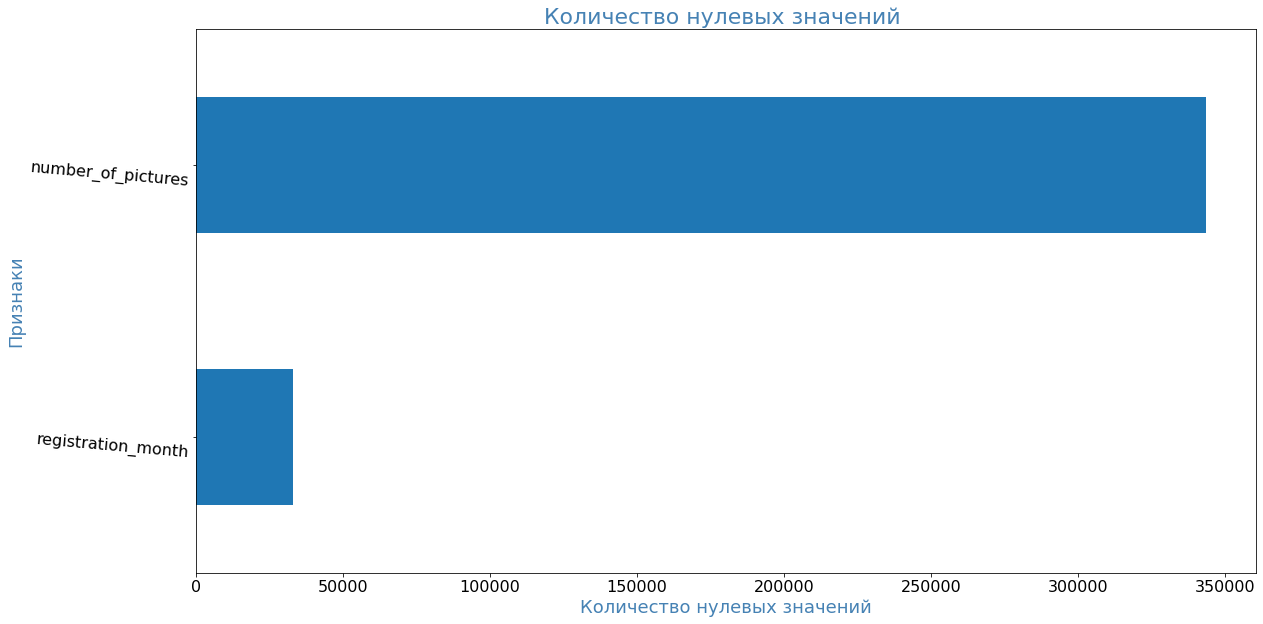

In [19]:
pass_value_zero_barh(df)

### Избавление от дубликатов

Найдём явные дубликаты

In [20]:
df.duplicated().sum()

4

Удалим дублирующиеся объекты

In [21]:
df.drop_duplicates(inplace=True)

In [22]:
df.duplicated().sum()

0

### Избавление от не информативных признаков

Скорее всего, такие признаки, как дата скачивания анкеты `date_crawled`, месяц регистрации `registration_month`, дата создания анкеты `date_created`, дата последней активности пользователя `last_seen` могут оказать лишь случайное влияние на цену автомобиля.  
Хотя для торговли характерна сезонность, маловероятно, что она оказывает значительное влияние на цену такого дорогого товара, как машина. То, как долго продавался конкретный автомобиль по конкретной цене, было бы полезной информацией - но не ясно, корректно ли это вычислять по дате создания анкеты и дате последней активности пользователя.  
Учитывать почтовый индекс владельца анкеты `postal_code` также представляется нерациональным. Хотя цена может отличаться в далёких друг от друга регионах, следует соотнести индексы с более крупной территориальной единицей - например, федеральным округом, - что требует отдельной работы.  
Признак `number_of_pictures` для всех объектов равен нулю.  
Удалим перечисленные признаки.

In [23]:
df.drop(labels=['date_crawled','registration_month','date_created','last_seen','postal_code','number_of_pictures'], 
        axis=1, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343592 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              343592 non-null  int64  
 1   vehicle_type       343592 non-null  object 
 2   registration_year  343592 non-null  int64  
 3   gearbox            343592 non-null  object 
 4   power              343592 non-null  float64
 5   model              343592 non-null  object 
 6   kilometer          343592 non-null  int64  
 7   fuel_type          343592 non-null  object 
 8   brand              343592 non-null  object 
 9   repaired           343592 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 28.8+ MB


### Избавление от выбивающихся численных значений

Посмотрим гистограммы по всем признакам, чтобы увидеть, есть ли явно выбивающиеся значения

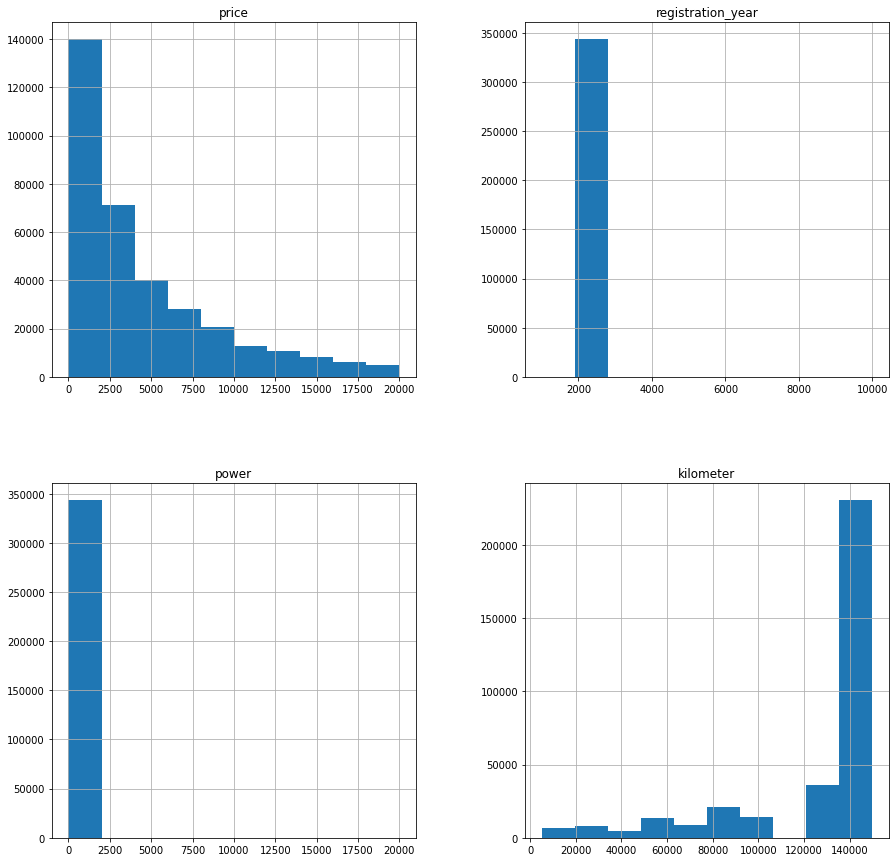

In [25]:
df.hist(figsize=(15, 15));

Мы видим, что в признаках `registration_year` и `power` присутствуют выбивающиеся значения. 
В случае `power` посмотрим, сколько их, отталкиваясь от границы (среднее +- 2 стандартных отклонения)

In [26]:
print('Для power',)
print('Меньше mean-2*std, объектов:',
      df[df['power']<(df['power'].mean()-2*df['power'].std())]['power'].count())
print('Больше mean+2*std, объектов:',
      df[df['power']>(df['power'].mean()+2*df['power'].std())]['power'].count())

Для power
Меньше mean-2*std, объектов: 0
Больше mean+2*std, объектов: 465


Поскольку подобных объектов мало, просто удалим их.

In [27]:
df.drop(df[df['power']>(df['power'].mean()+2*df['power'].std())].index, inplace=True)

В случае года регистрации автомобиля ясно, что он не может быть больше `date_created` (2016 год). Посмотрим на гистограмму поближе, чтобы оценить минимальный правдоподобный год регистрации. 

In [28]:
df.drop(df[df['registration_year']>2016].index, inplace=True)

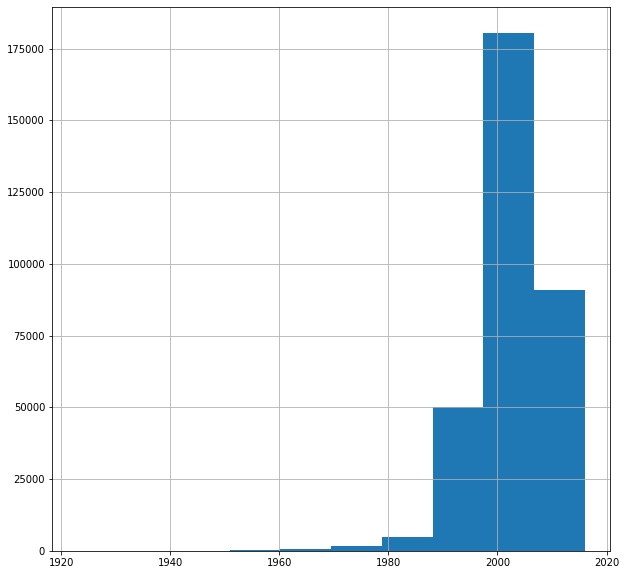

In [29]:
df[df['registration_year']>1920]['registration_year'].hist(figsize=(10, 10));

Отсечём объекты с регистрацией раньше 1970 года

In [30]:
df.drop(df[df['registration_year']<1970].index, inplace=True)

Хотя мы уже удалили нули из целевого признака `price`, в нём остались аномально маленькие для цены автомобиля значения. Посмотрим, сколько объектов имеет цену ниже (среднее - стандартное отклонение), и если таких немного, удалим их.

In [31]:
print('Для price')
print('Меньше mean-*std, объектов:',
      df[df['price']<(df['price'].mean()-df['price'].std())]['price'].count())

Для price
Меньше mean-*std, объектов: 1921


In [32]:
df.drop(df[df['price']<(df['price'].mean()-df['price'].std())].index, inplace=True)

Нулевых значений не осталось


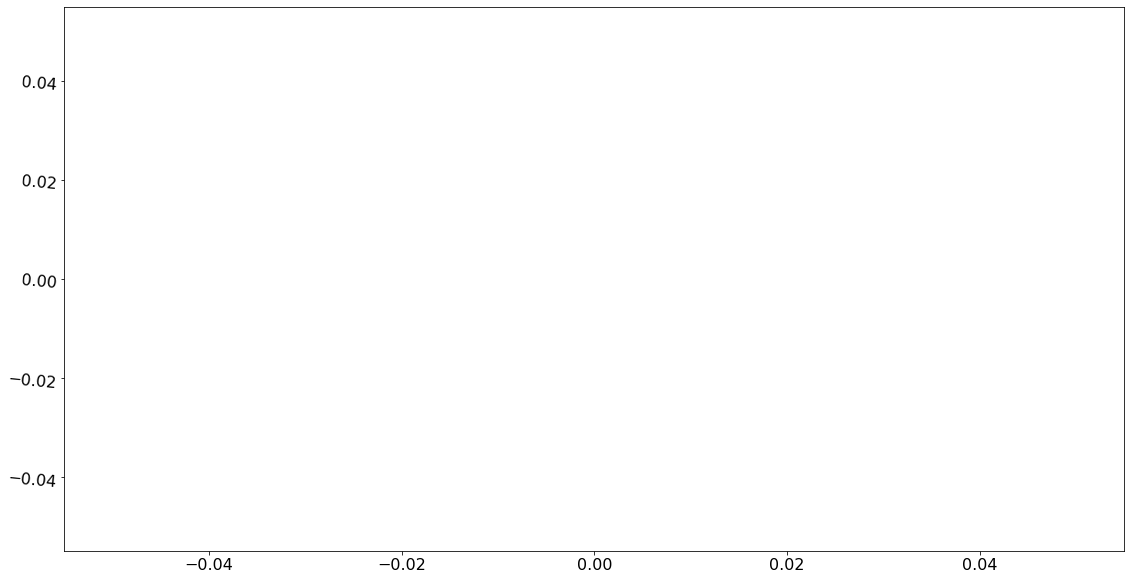

In [33]:
pass_value_zero_barh(df)

###  Разбивка данных на выборки и отделение целевого признака 

Отделим целевой признак (`target`) от остальных, необходимых для обучения моделей (`feature`), а затем разобьём данные на обучающую `train`, валидационную `validate` и тестовую `test` выборки в соотношении 3:1:1 соответственно

In [34]:
target = df['price']
features = df.drop(axis=1, labels = ['price'])

In [35]:
features_train, features_validate, target_train, target_validate = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

Проверим корректность разбивки

In [36]:
print('Обучающая :\t',features_train.shape,target_train.shape)
print('Валидационная :\t',features_validate.shape,target_validate.shape)
print('Тестовая :\t',features_test.shape,target_test.shape)

Обучающая :	 (195777, 9) (195777,)
Валидационная :	 (65259, 9) (65259,)
Тестовая :	 (65259, 9) (65259,)


### Кодирование категориальных признаков

Чтобы обучить такие модели, как случайный лес, нам необходимо, чтобы признаки приводились к численному типу `np.float32`. Воспользуемся порядковым кодированием категориальных признаков. Обучим кодировщик на обучающей выборке, затем трансформируем признаки во всех выборках

In [37]:
cols = ['vehicle_type','gearbox','model','fuel_type','brand','repaired']
encoder = OrdinalEncoder()
pd.set_option('mode.chained_assignment', None) # убираем предупреждения о работе с копиями
features_train.loc[:,cols] = encoder.fit_transform(features_train[cols]) # обучаем и трансформируем
features_validate.loc[:,cols] = encoder.transform(features_validate[cols]) # только трансформируем

In [38]:
features_test.head(10)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
115507,bus,2005,manual,75.0,other,70000,gasoline,suzuki,no
194933,suv,2006,manual,150.0,x_reihe,125000,gasoline,bmw,no
245680,small,1998,manual,101.0,golf,150000,petrol,volkswagen,no
190696,small,2008,manual,80.0,fiesta,90000,petrol,ford,no
153337,coupe,2000,manual,105.0,3er,150000,petrol,bmw,no
54026,sedan,2002,manual,82.0,a_klasse,150000,petrol,mercedes_benz,no
92130,sedan,2001,manual,97.0,corolla,150000,petrol,toyota,no
157551,sedan,2005,manual,140.0,golf,150000,gasoline,volkswagen,no
151258,small,1999,manual,50.0,polo,150000,petrol,volkswagen,no
38109,wagon,2011,manual,110.0,octavia,125000,gasoline,skoda,no


**Промежуточный вывод**  
Явные пропуски были обнаружены почти в 20% объектов. В первую очередь, отсутствовала информация о том, ремонтировалась машина или нет; меньше пропусков встречалось в технических характеристиках: тип коробки передач, тип топлива и тип кузова. Вполне возможно, что эти подробности отсутствовали в анкетах - люди могли ограничиться маркой и моделью. Действительно, марка автомобиля указана всегда. Однако в ~5,6% объектов имелись пропуски в модели. Стоит уточнить, не возник ли сбой при выгрузке данных.  
Мы заменили пропуски в типе коробки передач, топлива и кузова самыми часто встречающимися для данных моделей. Пропуски в моделях и информации о ремонте заменили на `unknown`.  
В признаках мощности, месяца регистрации и цены присутствовали неявные пропуски - нулевые значения. Поскольку цена - целевой признак, соответствующие объекты мы удалили, также как объекты с аномально маленькой ценой (всего 3% от выборки). Мощность вычислили как медианную для данной модели автомобиля.  
Количество фотографий для всех объектов равно нулю - вероятно, произошла ошибка при формировании или выгрузке данных. Мы исключили этот признак как неинформативный, наряду с датой скачивания анкеты, месяцем регистрации автомобиля, датой создания анкеты и датой последней активности пользователя. Если модель и обнаружила бы здесь связь с ценой, это произошло бы случайно.  
Мы исключили почтовый индекс владельца анкеты. Хотя цена может отличаться в далёких друг от друга регионах, следует соотнести индексы с более крупной территориальной единицей. В дальнейшем можно проделать такую работу.  
В признаках мощности, года регистрации и цены автомобиля найдены аномальные значения. Поскольку подобных объектов сильно меньше 1%, мы просто отбросили их. Для мощности мы взяли границу (среднее +- 2 стандартных отклонения); для года - с 1970 по 2016 (год создания большинства анкет); для цены - меньше (среднего - стандартное отклонение).  
Мы отделили целевой признак `price` и разбили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно. Затем преобразовали категориальные признаки порядковым кодированием, чтобы использовать их для обучения моделей градиентного бустинга и случайного леса

## Обучение моделей

### Обучение и оценка качества модели градиентного бустинга

Для обучения модели градиентного бустинга мы воспользуемся фреймворком `LightGBM`. При обучении переберём гиперпараметры: максимальная глубина дерева, количество итераций (estimators). Для оценки качества применим метрику RMSE (среднеквадратичная ошибка).

In [39]:
model_gb = None
rmse_gb = 10000
time_fit_gb = 0
time_pred_gb = 0
for depth in range(4, 7):
    for est in range(100,301,50):
        model = LGBMRegressor(random_state=12345, max_depth=depth, n_estimators=est, n_jobs=-1, verbose=10)
        start = time.time()
        model.fit(features_train,target_train)
        time_fit_gb_temp = time.time() - start
        start = time.time()
        predicted_validate = model.predict(features_validate)
        time_pred_gb_temp = time.time() - start
        rmse = mean_squared_error(target_validate, predicted_validate, squared=False)
        if rmse < rmse_gb:
            model_gb = model
            rmse_gb = rmse
            time_fit_gb = time_fit_gb_temp
            time_pred_gb = time_pred_gb_temp

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.760539
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180382
[LightGBM] [Debug] init for col-wise cost 0.287327 seconds, init for row-wise cost 0.195223 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 195777, number of used features: 9
[LightGBM] [Info] Start training from score 4627.612855
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Traine

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.760539
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180382
[LightGBM] [Debug] init for col-wise cost 0.004140 seconds, init for row-wise cost 0.089809 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 195777, number of used features: 9
[LightGBM] [Info] Start training from score 4627.612855
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained 

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 13 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[Ligh

[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with l

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180382
[LightGBM] [Debug] init for col-wise cost 0.192351 seconds, init for row-wise cost 0.004358 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 195777, number of used features: 9
[LightGBM] [Info] Start training from score 4627.612855
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with lea

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 25 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 23 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No furthe

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 29 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 24 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 26 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 18 and depth = 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 5
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.760539
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180382
[LightGBM] [Debug] init for col-wise cost 0.003842 seconds, init for row-wise cost 0.003919 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 195777, number of used features: 9
[LightGBM] [Info] Start training from score 4627.612855
[Light

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 28 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.760539
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180382
[LightGBM] [Debug] init for col-wise cost 0.003649 seconds, init for row-wise cost 0.098617 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198063 seconds.
You can set `force_row_wise=true` to remove the ove

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[Ligh

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Traine

In [40]:
print('Для градиентного бустинга\nс максимальной глубиной\t\t\t', model_gb.max_depth)
print('и количеством итераций (estimators)\t', model_gb.n_estimators)
print('RMSE = \t\t\t\t\t {:.5}'.format(rmse_gb))
print('Время на обучение \t\t\t {:.5} секунд'.format(time_fit_gb))
print('Время на предсказание\t\t\t {:.5} секунд'.format(time_pred_gb))

Для градиентного бустинга
с максимальной глубиной			 6
и количеством итераций (estimators)	 300
RMSE = 					 1656.3
Время на обучение 			 12.692 секунд
Время на предсказание			 1.3128 секунд


### Обучение и оценка качества модели случайного леса

Обучим модель случайного леса, перебирая максимальную глубину деревьев и количество деревьев. 

In [41]:
model_rf = None
rmse_rf = 10000
time_fit_rf = 0
time_pred_rf = 0
for depth in range(4, 8):
    for est in range(100,301,50):
        model = RandomForestRegressor(random_state=1234, max_depth=depth, n_estimators=est, 
                                      criterion='friedman_mse', max_features='sqrt', n_jobs=-1, verbose=10)
        start = time.time()
        model.fit(features_train,target_train)
        time_fit_rf_temp = time.time() - start
        start = time.time()
        predicted_validate = model.predict(features_validate)
        time_pred_rf_temp = time.time() - start
        rmse = mean_squared_error(target_validate, predicted_validate, squared=False)
        if rmse < rmse_rf:
            model_rf = model
            rmse_rf = rmse
            time_fit_rf = time_fit_rf_temp
            time_pred_rf = time_pred_rf_temp

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s


building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s


building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.4s remaining:    0.0s


building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 o

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s


building tree 5 of 200
building tree 6 of 200
building tree 7 of 200


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 o

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   16.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s


building tree 9 of 300
building tree 10 of 300
building tree 11 of 300


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 150
building tree 2 of 150
building tree 3 of 150


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 150
building tree 5 of 150
building tree 6 of 150


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


building tree 7 of 150
building tree 8 of 150
building tree 9 of 150


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 200
building tree 5 of 200
building tree 6 of 200


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


building tree 7 of 200
building tree 8 of 200
building tree 9 of 200


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 250
building tree 2 of 250
building tree 3 of 250


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 250
building tree 5 of 250
building tree 6 of 250


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s


building tree 7 of 250
building tree 8 of 250
building tree 9 of 250


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   18.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend wit

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


building tree 4 of 300
building tree 5 of 300
building tree 6 of 300


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s


building tree 7 of 300
building tree 8 of 300
building tree 9 of 300


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.7s remaining:    0.0s


building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.1s finished


In [42]:
print('Для случайного леса\nс максимальной глубиной\t\t\t', model_rf.max_depth)
print('и количеством деревьев (estimators)\t', model_rf.n_estimators)
print('RMSE = \t\t\t\t\t {:.5}'.format(rmse_rf))
print('Время на обучение \t\t\t {:.5} секунд'.format(time_fit_rf))
print('Время на предсказание\t\t\t {:.5} секунд'.format(time_pred_rf))

Для случайного леса
с максимальной глубиной			 7
и количеством деревьев (estimators)	 250
RMSE = 					 2092.5
Время на обучение 			 18.795 секунд
Время на предсказание			 0.83478 секунд


### Обучение и оценка качества модели линейной регрессии

Обучим и оценим качество модели линейной регрессии. Чтобы улучшить результаты, стандартизируем численные признаки и перекодируем категориальные признаки прямым методом.

In [43]:
# производим обратную трансформацию порядкового кодирования
features_train.loc[:,cols] = encoder.inverse_transform(features_train[cols])
features_validate.loc[:,cols] = encoder.inverse_transform(features_validate[cols])

In [45]:
# стандартизируем численные признаки
cols_std = ['registration_year','power','kilometer']
scaler_std = StandardScaler()
features_train.loc[:,cols_std] = scaler_std.fit_transform(features_train[cols_std]) # обучаем и трансформируем
features_validate.loc[:,cols_std] = scaler_std.transform(features_validate[cols_std]) # только трансформируем

In [58]:
features_validate.head(10)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
6151,bus,0.19,auto,-0.27,touran,0.58,gasoline,volkswagen,no
330453,wagon,-0.90,manual,-0.56,golf,0.58,petrol,volkswagen,no
58085,suv,0.82,manual,0.32,kuga,-1.84,gasoline,ford,no
327852,small,0.82,manual,-1.14,fabia,-0.76,petrol,skoda,no
81242,sedan,-1.37,manual,-1.14,golf,0.58,petrol,volkswagen,no
342714,small,-1.52,manual,-1.43,polo,0.58,petrol,volkswagen,no
50884,sedan,0.51,manual,0.11,mondeo,-1.30,petrol,ford,unknown
231108,sedan,0.04,manual,0.22,passat,0.58,petrol,volkswagen,no
132944,sedan,0.51,auto,5.16,unknown,0.58,petrol,mercedes_benz,no
231292,sedan,1.60,manual,0.42,qashqai,-2.65,petrol,nissan,no


In [47]:
# прямое кодирование признаков с помощью OneHotEncoder
# воспользуемся трансформером, чтобы не пришлось дополнительно соединять закодированные признаки с числовыми
transformer_ohe = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cols),
    remainder='passthrough')

features_train_ohe = pd.DataFrame(transformer_ohe.fit_transform(features_train).toarray(), 
                                  columns=transformer_ohe.get_feature_names())
features_validate_ohe = pd.DataFrame(transformer_ohe.transform(features_validate).toarray(), 
                                  columns=transformer_ohe.get_feature_names())

In [48]:
# проверяем размерность
print('Обучающая :\t',features_train_ohe.shape)
print('Валидационная :\t',features_validate_ohe.shape)

Обучающая :	 (195777, 313)
Валидационная :	 (65259, 313)


In [49]:
model_lr = LinearRegression(n_jobs=-1)
start = time.time()
model_lr.fit(features_train_ohe,target_train)
time_fit_lr = time.time() - start
start = time.time()
predicted_validate = model_lr.predict(features_validate_ohe)
time_pred_lr = time.time() - start
rmse_lr = mean_squared_error(target_validate, predicted_validate, squared=False)

In [50]:
print('Для линейной регрессии')
print('RMSE = \t\t\t\t\t {:.5}'.format(rmse_lr))
print('Время на обучение \t\t\t {:.5} секунд'.format(time_fit_lr))
print('Время на предсказание\t\t\t {:.5} секунд'.format(time_pred_lr))

Для линейной регрессии
RMSE = 					 2620.7
Время на обучение 			 20.034 секунд
Время на предсказание			 0.11607 секунд


### Сравнение качества моделей

Сопоставим метрики построенных нами моделей

In [51]:
quality = pd.DataFrame([['Градиентный бустинг', rmse_gb, time_fit_gb, time_pred_gb],
                       ['Случайный лес', rmse_rf, time_fit_rf, time_pred_rf],
                       ['Линейная регрессия', rmse_lr, time_fit_lr, time_pred_lr]],
    columns=['Модель', 'RMSE','Обучение, сек','Предсказание, сек'])
pd.options.display.float_format = '{:.2f}'.format

In [52]:
quality

,Модель,RMSE,"Обучение, сек","Предсказание, сек"
0,Градиентный бустинг,1656.35,12.69,1.31
1,Случайный лес,2092.54,18.80,0.83
2,Линейная регрессия,2620.72,20.03,0.12


**Промежуточный вывод**  
Наилучшее значение метрики качества RMSE (1656) показала модель градиентного бустинга с максимальной глубиной 6 и количеством итераций (estimators) 300.
У модель случайного леса с максимальной глубиной 7 и количеством деревьев (estimators) 250 выше (хуже) RMSE: 2092 (на 28%). Также в ~1.5 раза дольше обучалась (20 секунд против 13 у градиентного бустинга). Однако случайный лес чуть быстрее давал предсказание: 0.83 секунды против 1.3 (градиентный бустинг на 34% медленнее).  
Модель линейной регрессии дольше обучилась, хотя дала предсказание почти мгновенно (менее 0,1 секунды), однако RMSE оказалась выше требуемого: 2620 вместо 2500.  
Учитывая, что мы делали прогноз по базе данных анкет почти за год, выигрыш случайного леса в прогнозировании (0,5 секунды) кажется недостаточным, чтобы компенсировать проигрыш в скорости обучения и RMSE. Потому мы выберем модель градиентного бустинга

## Анализ моделей

### Проверка качества лучшей модели на тестовой выборке

Проверим метрику RMSE и время предсказания для выбранной нами лучшей модели градиентного бустинга на тестовой выборке.

In [53]:
# перед началом закодируем категориальные признаки в тестовой выборке
features_test.loc[:,cols] = encoder.transform(features_test[cols])

In [54]:
start = time.time()
predicted_test = model_gb.predict(features_test)
time_pred_final = time.time() - start
rmse_final = mean_squared_error(target_test, predicted_test, squared=False)

In [55]:
print('Для выбранной нами модели градиентного бустинга')
print('RMSE = \t\t\t {:.5}'.format(rmse_final))
print('Время на предсказание\t {:.5} секунд'.format(time_pred_final))

Для выбранной нами модели градиентного бустинга
RMSE = 			 1620.5
Время на предсказание	 1.3287 секунд


RMSE и время, затраченное на предсказание, почти не отличаются от значений, полученных на валидационной выборке. Это указывает на стабильность (не переобученность) модели.

### Проверка лучшей модели на адекватность

Сравним выбранную нами модель градиентного бустинга со случайной моделью, чьи предсказания всегда равны среднему значению целевого признака в обучающей выборке

In [56]:
model_dummy = DummyRegressor(strategy='mean')
model_dummy.fit(features_train,target_train)
predicted_dummy = model_dummy.predict(features_test)
rmse_dummy = mean_squared_error(target_test, predicted_dummy, squared=False)

In [57]:
print('Для простой модели')
print('RMSE = {:.5}'.format(rmse_dummy))

Для простой модели
RMSE = 4531.8


**Промежуточный вывод**  
Целевой показатель качества достигнут (RMSE = 1620).  
Выбранная модель прошла проверку на адекватность в сравнении с простой случайной моделью (RMSE модели градиентного бустинга в 2,75 раз ниже).

## Общий вывод

1. Явные пропуски обнаружены в 20% объектов. В основном это касается информации о том, ремонтировалась ли машина. Возможно, такие подробности, как тип коробки передач, тип топлива и тип кузова действительно казались авторам анкет излишними в сравнении с маркой (указана всегда) и моделью автомобиля. Однако даже модель пропущена в ~5,6% случаев. Стоит уточнить, не возник ли сбой при выгрузке данных
2. В признаках мощности, месяца регистрации и цены присутствовали неявные пропуски - нулевые значения. 
3. Количество фотографий для всех объектов равно нулю - вероятно, произошла ошибка при формировании или выгрузке данных.
4. Мы исключили неинформативные признаки: дата скачивания анкеты, месяц регистрации автомобиля, дата создания анкеты и дата последней активности пользователя.
5. Мы исключили почтовый индекс владельца анкеты. Хотя цена может отличаться в далёких друг от друга регионах, следует соотнести индексы с более крупной территориальной единицей. В дальнейшем можно проделать такую работу.  
6. Наилучшее значение метрики качества RMSE (1656) показала модель градиентного бустинга с максимальной глубиной 6 и количеством итераций (estimators) 300. Она обучалась 13 секунд и давала предсказание за 1,3 секунды.  
7. Модель случайного леса с максимальной глубиной 7 и количеством деревьев (estimators) 250 хуже RMSE: 2092 (на 28%). Также она в ~1.5 раза дольше обучалась (20 секунд). Хотя случайный лес чуть быстрее давал предсказание (0.8 секунды), мы работали с массивом анкет почти за год, так что такой выигрыш кажется недостаточным.
8. Модель линейной регрессии предсказывает почти мгновенно, но даёт неудовлетворителньое качество RMSE: 2620 (при требуемых 2500).
9. Метрики модели градиентного бустинга на тестовой выборке почти идентичны метрикам на валидационной выборке, что свидетельствует о стабильности (не переобученности) модели. RMSE равна 1620 при требуемых 2500. Модель прошла проверку на адекватность в сравнении со случайной моделью.